### Threshold CCLE CNV log-ratios into binary gain/loss calls

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

In [2]:
if os.path.isfile(cfg.ccle_cnv_ratios):
    ccle_cnv_df = pd.read_csv(cfg.ccle_cnv_ratios, sep=',', index_col=0)
else:
    print('Loading CNV info from CCLE download page...', file=sys.stderr)
    # URL from CCLE public download data:
    # https://depmap.org/portal/download/
    ccle_cnv_df = pd.read_csv(
        'https://figshare.com/ndownloader/files/38357438',
        sep=',', index_col=0
    )
    os.makedirs(os.path.join(cfg.data_dir, 'ccle'), exist_ok=True)
    ccle_cnv_df.to_csv(cfg.ccle_cnv_ratios)

print(ccle_cnv_df.shape)
print(ccle_cnv_df.columns)
ccle_cnv_df.iloc[:5, :5]

(1775, 25368)
Index(['DDX11L1 (84771)', 'WASH7P (653635)', 'MIR6859-1 (102466751)',
       'MIR1302-2 (100302278)', 'FAM138A (645520)', 'OR4F5 (79501)',
       'WASH9P (102723897)', 'MIR6859-2 (102465909)', 'OR4F29 (729759)',
       'AL669831.3 (101928626)',
       ...
       'BPY2C (442868)', 'TTTY4C (474150)', 'CSPG4P1Y (114758)', 'CDY1 (9085)',
       'TTTY3 (114760)', 'SNORD38B (94163)', 'SCARNA4 (677771)',
       'SNORA50A (677830)', 'SNORD3D (780854)', 'POLR2J3 (548644)'],
      dtype='object', length=25368)


,DDX11L1 (84771),WASH7P (653635),MIR6859-1 (102466751),MIR1302-2 (100302278),FAM138A (645520)
ACH-000759,1.675758,1.675758,1.675758,1.675758,1.675758
ACH-000681,0.775472,0.775472,0.775472,0.775472,0.775472
ACH-000769,2.988233,2.988233,2.988233,2.988233,2.988233
ACH-002291,0.790799,0.790799,0.790799,0.790799,0.790799
ACH-000853,1.083618,1.083618,1.083618,1.083618,1.083618


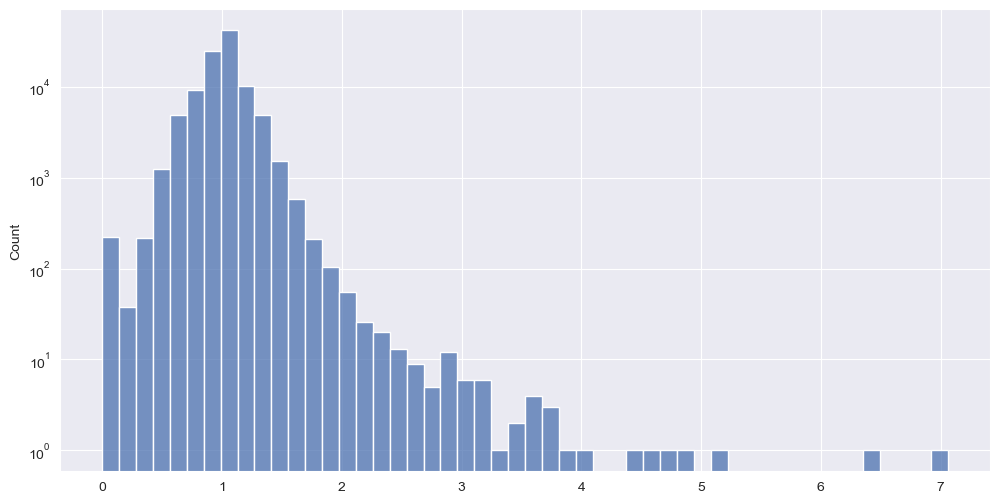

In [3]:
sns.set({'figure.figsize': (12, 6)})
ratio_samples = np.random.choice(ccle_cnv_df.values.flatten(), size=100000)
g = sns.histplot(ratio_samples, bins=50)
g.set_yscale('log')

In [4]:
# we're using both of these just as rough thresholds that seem to work well
# (i.e. give a decent number of samples labeled as 0/1), since observed
# log-ratios are dependent on tumor purity even in full CN gain/loss situations

# log_2(5/2) = log_2(1 + 3/2), or a full copy gain
gain_threshold = 1.322

# log_2(3/2) = log_2(1 + 1/2), or a full copy loss
loss_threshold = 0.585

copy_loss_df = (ccle_cnv_df
    .fillna(0)
    .astype(float)
    .where(ccle_cnv_df < loss_threshold, 0)
    .where(ccle_cnv_df >= loss_threshold, 1)
    .astype(int)
)

# just use gene symbols as column names
copy_loss_df.columns = copy_loss_df.columns.str.split(' ', expand=True).get_level_values(0)

print(np.unique(copy_loss_df.values.flatten(), return_counts=True))
copy_loss_df.iloc[:5, :5]

(array([0, 1]), array([43930274,  1097926]))


,DDX11L1,WASH7P,MIR6859-1,MIR1302-2,FAM138A
ACH-000759,0,0,0,0,0
ACH-000681,0,0,0,0,0
ACH-000769,0,0,0,0,0
ACH-002291,0,0,0,0,0
ACH-000853,0,0,0,0,0


In [5]:
copy_loss_df.sum()['TP53']

59

In [6]:
copy_loss_df.to_csv(cfg.ccle_cnv_loss, sep='\t')

In [7]:
copy_gain_df = (ccle_cnv_df
    .fillna(0)
    .astype(float)
    .where(ccle_cnv_df > gain_threshold, 0)
    .where(ccle_cnv_df <= gain_threshold, 1)
    .astype(int)
)

# get rid of entrez IDs and just use gene symbols as column names 
copy_gain_df.columns = copy_gain_df.columns.str.split(' ', expand=True).get_level_values(0)

print(np.unique(copy_gain_df.values.flatten(), return_counts=True))
copy_gain_df.iloc[:5, :5]

(array([0, 1]), array([42760550,  2267650]))


,DDX11L1,WASH7P,MIR6859-1,MIR1302-2,FAM138A
ACH-000759,1,1,1,1,1
ACH-000681,0,0,0,0,0
ACH-000769,1,1,1,1,1
ACH-002291,0,0,0,0,0
ACH-000853,0,0,0,0,0


In [8]:
copy_gain_df.sum()['KRAS']

192

In [9]:
copy_gain_df.to_csv(cfg.ccle_cnv_gain, sep='\t')